In [1]:
import numpy as np
from quad_interp import quad_interp_mod


# Define input values
lon = np.float64(255.070312500000)  # Interpolation point longitude (degrees)
lat = np.float64(74.4735717773438)  # Interpolation point latitude (degrees)


x_corners = np.array([253.978338312172, 254.698325218660, 256.152459376863, 255.464594303337], dtype=np.float64)
y_corners = np.array([74.4775053981321, 74.2803767364551, 74.6534788353970, 74.8496146897753], dtype=np.float64)
p = np.array([0.04222093679422526, 0.02939444349332336, 0.02361927128232367, 0.02457275269829678], dtype=np.float64)  # Values at the quadrilateral corners

# Prepare output variable
expected_obs = np.zeros(1, dtype=np.float64)

# this call is so init location_mod is called, and does all its print outs
expected_obs = quad_interp_mod.quad_idw_interp_f2py(
        lon, lat, x_corners, y_corners, p
)

print(f"Interpolated value at ({lon}, {lat}): {expected_obs}")

Interpolated value at (255.0703125, 74.4735717773438): 0.03081763984660563
 --------------------------------------
 Starting ... at YYYY MM DD HH MM SS = 
                 2025 10 31 15 49 34
 --------------------------------------

  set_nml_output No echo of NML values
  location_mod: using code with optimized cutoffs
  location_mod: Including vertical separation when computing distances:
  location_mod:        # pascals ~ 1 horiz radian:      100000.00000
  location_mod:         # meters ~ 1 horiz radian:       10000.00000
  location_mod:   # model levels ~ 1 horiz radian:          20.00000
  location_mod:  # scale heights ~ 1 horiz radian:           5.00000



## Plot of interpolation over grid cell

Interpolated z value at (255.0703125, 74.4735717773438): 0.03081763984660563


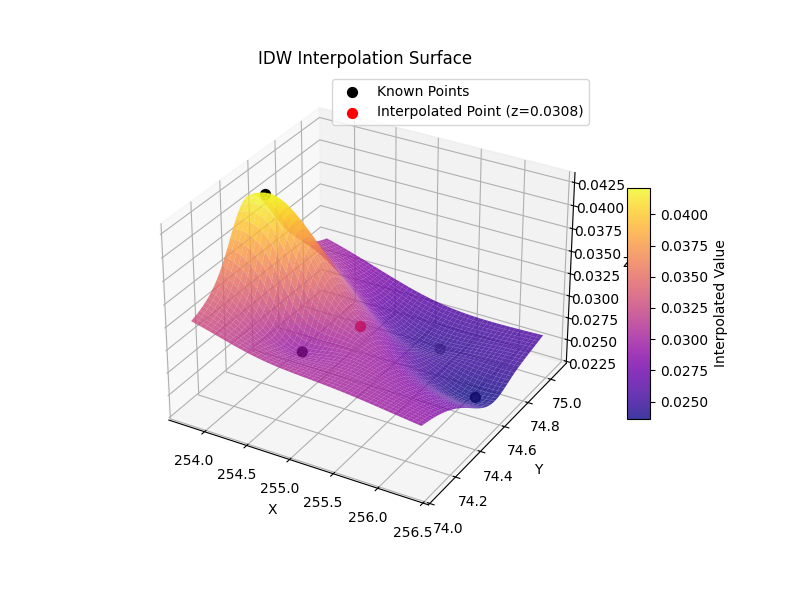

In [2]:
import numpy as np
import matplotlib.pyplot as plt

lon = np.float64(255.070312500000)  # Interpolation point longitude (degrees)
lat = np.float64(74.4735717773438)  # Interpolation point latitude (degrees)

x_corners = np.array([253.978338312172, 254.698325218660, 256.152459376863, 255.464594303337], dtype=np.float64)
y_corners = np.array([74.4775053981321, 74.2803767364551, 74.6534788353970, 74.8496146897753], dtype=np.float64)
p = np.array([0.04222093679422526, 0.02939444349332336, 0.02361927128232367, 0.02457275269829678], dtype=np.float64)  # Values at the quadrilateral corners

# Define Grid for Interpolation
x_min, x_max = min(x_corners), max(x_corners)
y_min, y_max = min(y_corners), max(y_corners)

# Add some padding to the grid range for better visualization
padding = 0.1 * (x_max - x_min)
grid_x, grid_y = np.meshgrid(
    np.linspace(x_min - padding, x_max + padding, 50),
    np.linspace(y_min - padding, y_max + padding, 50)
)
grid_z = np.zeros_like(grid_x)

# Compute IDW for Each Grid Point
for i in range(grid_x.shape[0]):
    for j in range(grid_x.shape[1]):
        grid_z[i, j] = expected_obs = quad_interp_mod.quad_idw_interp_f2py(grid_x[i,j], grid_y[i,j], x_corners, y_corners, p)

# Interpolated point
interpolated_point = (255.070312500000, 74.4735717773438)


# Calculate the interpolated z value for the given point
interpolated_z = quad_interp_mod.quad_idw_interp_f2py(interpolated_point[0], interpolated_point[1], x_corners, y_corners, p)
print(f"Interpolated z value at {interpolated_point}: {interpolated_z}")


# Plot the Results as a Surface
%matplotlib widget
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(grid_x, grid_y, grid_z, cmap='plasma', edgecolor='none', alpha=0.8)
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10, label="Interpolated Value")

# Add known points
ax.scatter(x_corners, y_corners, p, color='k', label="Known Points", s=50)

# Add the interpolated point
ax.scatter(
    interpolated_point[0], interpolated_point[1], interpolated_z,
    color='red', label=f"Interpolated Point (z={interpolated_z:.4f})", s=50
)

# Set labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("IDW Interpolation Surface")
plt.legend()
plt.show()

In [3]:
x_corners = np.array([253.978338312172, 254.698325218660, 256.152459376863, 255.464594303337], dtype=np.float64)
y_corners = np.array([74.4775053981321, 74.2803767364551, 74.6534788353970, 74.8496146897753], dtype=np.float64)
p = np.array([0.04222093679422526, 0.02939444349332336, 0.02361927128232367, 0.02457275269829678], dtype=np.float64)

# 1. Test corners
print("Corner tests:")
for i in range(4):
    val = quad_interp_mod.quad_idw_interp_f2py(x_corners[i], y_corners[i], x_corners, y_corners, p)
    print(f"Corner {i}: expected {p[i]}, got {val}")
    assert np.isclose(val, p[i]), f"Corner {i} failed"
    

# 3. Test centroid (inside quad)
x_centroid = np.mean(x_corners)
y_centroid = np.mean(y_corners)
val = quad_interp_mod.quad_idw_interp_f2py(x_centroid, y_centroid, x_corners, y_corners, p)
print(f"\nCentroid: got {val}, should be between {p.min()} and {p.max()}")
assert p.min() <= val <= p.max(), "Centroid out of bounds"

# 4. Test bounds for random interior points
print("\nRandom interior points:")
rng = np.random.default_rng(42)
for _ in range(5):
    weights = rng.uniform(0, 1, 4)
    weights /= weights.sum()
    x_rand = np.dot(weights, x_corners)
    y_rand = np.dot(weights, y_corners)
    val = quad_interp_mod.quad_idw_interp_f2py(x_rand, y_rand, x_corners, y_corners, p)
    print(f"Random interior: got {val}")
    assert p.min() <= val <= p.max(), "Random interior point out of bounds"


# 5. Test edge midpoints
print("\nEdge midpoint tests:")
for i in range(4):
    j = (i + 1) % 4
    x_mid = (x_corners[i] + x_corners[j]) / 2
    y_mid = (y_corners[i] + y_corners[j]) / 2
    val = quad_interp_mod.quad_idw_interp_f2py(x_mid, y_mid, x_corners, y_corners, p)
    print(f"Edge {i}-{j} midpoint: got {val}, should be between {p[i]} and {p[j]}")
    assert p.min() <= val <= p.max(), f"Edge {i}-{j} midpoint out of bounds"



print("\nAll tests passed!")

Corner tests:
Corner 0: expected 0.04222093679422526, got 0.04222093679422526
Corner 1: expected 0.02939444349332336, got 0.02939444349332336
Corner 2: expected 0.02361927128232367, got 0.02361927128232367
Corner 3: expected 0.02457275269829678, got 0.02457275269829678

Centroid: got 0.029868644506964612, should be between 0.02361927128232367 and 0.04222093679422526

Random interior points:
Random interior: got 0.028807746405414874
Random interior: got 0.027899699960908075
Random interior: got 0.0267456609700944
Random interior: got 0.03229329765798335
Random interior: got 0.02664594933502674

Edge midpoint tests:
Edge 0-1 midpoint: got 0.035146542068040305, should be between 0.04222093679422526 and 0.02939444349332336
Edge 1-2 midpoint: got 0.028725927443283807, should be between 0.02939444349332336 and 0.02361927128232367
Edge 2-3 midpoint: got 0.02473204202503187, should be between 0.02361927128232367 and 0.02457275269829678
Edge 3-0 midpoint: got 0.03103782189368074, should be betw

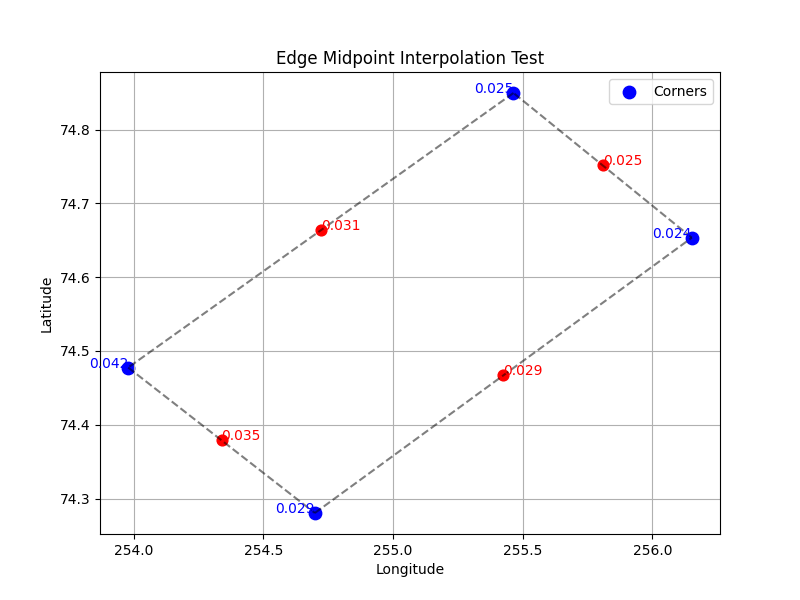

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
# Plot quad corners
plt.scatter(x_corners, y_corners, color='blue', label='Corners', s=80)
for i in range(4):
    plt.text(x_corners[i], y_corners[i], f'{p[i]:.3f}', color='blue', fontsize=10, ha='right')

# Plot edges and midpoints
for i in range(4):
    j = (i + 1) % 4
    # Draw edge
    plt.plot([x_corners[i], x_corners[j]], [y_corners[i], y_corners[j]], 'k--', alpha=0.5)
    # Compute midpoint
    x_mid = (x_corners[i] + x_corners[j]) / 2
    y_mid = (y_corners[i] + y_corners[j]) / 2
    val = quad_interp_mod.quad_idw_interp_f2py(x_mid, y_mid, x_corners, y_corners, p)
    # Plot midpoint
    plt.scatter(x_mid, y_mid, color='red', s=60)
    plt.text(x_mid, y_mid, f'{val:.3f}', color='red', fontsize=10, ha='left')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Edge Midpoint Interpolation Test')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
#  Test edge midpoints great circle
def great_circle_midpoint(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])
    # Convert to Cartesian coordinates
    x1, y1, z1 = np.cos(lat1)*np.cos(lon1), np.cos(lat1)*np.sin(lon1), np.sin(lat1)
    x2, y2, z2 = np.cos(lat2)*np.cos(lon2), np.cos(lat2)*np.sin(lon2), np.sin(lat2)
    # Average and normalize
    x, y, z = (x1 + x2)/2, (y1 + y2)/2, (z1 + z2)/2
    norm = np.sqrt(x**2 + y**2 + z**2)
    x, y, z = x/norm, y/norm, z/norm
    # Convert back to lon/lat
    lat_mid = np.arcsin(z)
    lon_mid = np.arctan2(y, x)
    lon_mid_deg = np.rad2deg(lon_mid) % 360  # Ensure 0 <= lon < 360
    lat_mid_deg = np.rad2deg(lat_mid)
    return lon_mid_deg, lat_mid_deg

# Edge midpoint tests using great circle midpoints
print("\nGreat circle edge midpoint tests:")
for i in range(4):
    j = (i + 1) % 4
    x_mid, y_mid = great_circle_midpoint(x_corners[i], y_corners[i], x_corners[j], y_corners[j])
    val = quad_interp_mod.quad_idw_interp_f2py(x_mid, y_mid, x_corners, y_corners, p)
    print(f"Edge {i}-{j} great circle midpoint: got {val}, should be between {p[i]} and {p[j]}")
    assert p.min() <= val <= p.max(), f"Edge {i}-{j} midpoint out of bounds"


Great circle edge midpoint tests:
Edge 0-1 great circle midpoint: got 0.03512685923246021, should be between 0.04222093679422526 and 0.02939444349332336
Edge 1-2 great circle midpoint: got 0.028760049920204218, should be between 0.02939444349332336 and 0.02361927128232367
Edge 2-3 great circle midpoint: got 0.024729434113747874, should be between 0.02361927128232367 and 0.02457275269829678
Edge 3-0 great circle midpoint: got 0.031091848166523786, should be between 0.02457275269829678 and 0.04222093679422526


In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """Great circle distance in degrees between two (lon, lat) points."""
    # Convert degrees to radians, ensure float64
    lon1 = np.float64(lon1)
    lat1 = np.float64(lat1)
    lon2 = np.float64(lon2)
    lat2 = np.float64(lat2)
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return np.rad2deg(c)  # Return distance in degrees

# Reference point (can be anywhere)
ref_lon = np.float64(12.0)  # or 255.0 12.0
ref_lat = np.float64(34.5)  # or 74.5. 34.0

def gc_func(lon, lat):
    """Function of great circle distance from reference point."""
    lon = np.float64(lon)
    lat = np.float64(lat)
    dist = haversine(lon, lat, ref_lon, ref_lat)
    return np.cos(np.deg2rad(dist))  # Example: cosine of distance

# Set p to gc_func values at corners
p = gc_func(x_corners.astype(np.float64), y_corners.astype(np.float64))

# Test at centroid
x_test = np.float64(np.mean(x_corners))
y_test = np.float64(np.mean(y_corners))
# Test at corner
#x_test = x_corners[3].astype(np.float64)
#y_test = y_corners[3].astype(np.float64)

expected = gc_func(x_test, y_test)
val = quad_interp_mod.quad_idw_interp_f2py(x_test, y_test, x_corners.astype(np.float64), y_corners.astype(np.float64), p)
print(f"Centroid: expected {expected}, got {val}")
assert np.isclose(val, expected), f"Test point failed: expected {expected}, got {val}"

Centroid: expected 0.446661971076024, got 0.4466891833324308


AssertionError: Test point failed: expected 0.446661971076024, got 0.4466891833324308

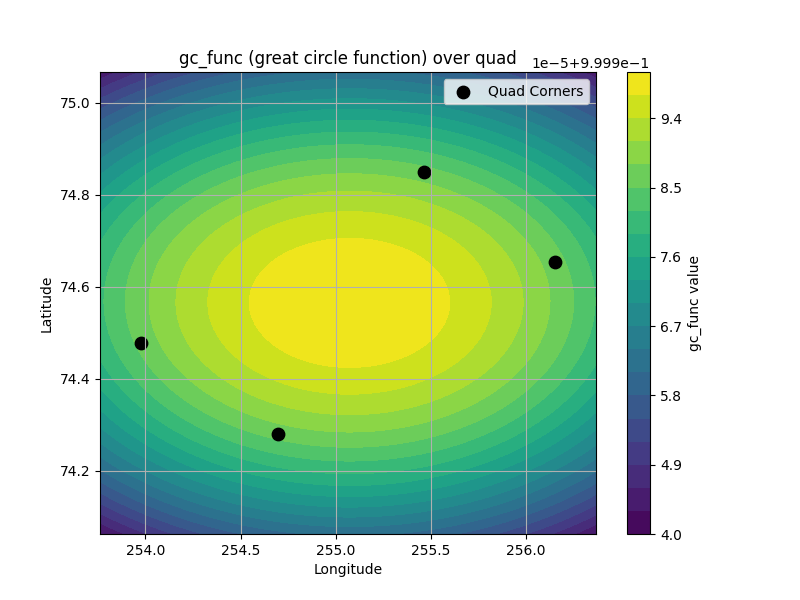

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create grid covering the quad
x_min, x_max = min(x_corners), max(x_corners)
y_min, y_max = min(y_corners), max(y_corners)
padding = 0.1 * (x_max - x_min)
grid_x, grid_y = np.meshgrid(
    np.linspace(x_min - padding, x_max + padding, 100),
    np.linspace(y_min - padding, y_max + padding, 100)
)

# Evaluate gc_func on grid
grid_gc = gc_func(grid_x, grid_y)

plt.figure(figsize=(8, 6))
contour = plt.contourf(grid_x, grid_y, grid_gc, levels=20, cmap='viridis')
plt.colorbar(contour, label='gc_func value')
plt.scatter(x_corners, y_corners, color='black', label='Quad Corners', s=80)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('gc_func (great circle function) over quad')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

def haversine(lon1, lat1, lon2, lat2):
    """Great circle distance in degrees between two (lon, lat) points."""
    lon1, lat1, lon2, lat2 = map(np.deg2rad, map(np.float64, [lon1, lat1, lon2, lat2]))
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return np.rad2deg(c)  # Return distance in degrees

# Reference point (center of Gaussian)
#ref_lon = np.float64(np.mean(x_corners))
#ref_lat = np.float64(np.mean(y_corners))
ref_lon = x_corners[0].astype(np.float64)
ref_lat = y_corners[0].astype(np.float64)


def spherical_gaussian(lon, lat, sigma=500.0):
    """
    Spherical Gaussian centered at (ref_lon, ref_lat)
    sigma : width of Gaussian in degrees
    """
    lon = np.float64(lon)
    lat = np.float64(lat)
    dist = haversine(lon, lat, ref_lon, ref_lat)
    return np.exp(-(dist**2) / (2 * sigma**2))

# Example usage at quad corners
p = spherical_gaussian(x_corners.astype(np.float64), y_corners.astype(np.float64))

# Test at centroid
x_test = np.float64(np.mean(x_corners))
y_test = np.float64(np.mean(y_corners))

expected = spherical_gaussian(x_test, y_test)
val = quad_interp_mod.quad_idw_interp_f2py(
    x_test, y_test,
    x_corners.astype(np.float64),
    y_corners.astype(np.float64),
    p.astype(np.float64)
)

print(f"Centroid: expected {expected}, got {val}")
assert np.isclose(val, expected), f"Test point failed: expected {expected}, got {val}"


Centroid: expected 1.0, got 0.9999998171775384


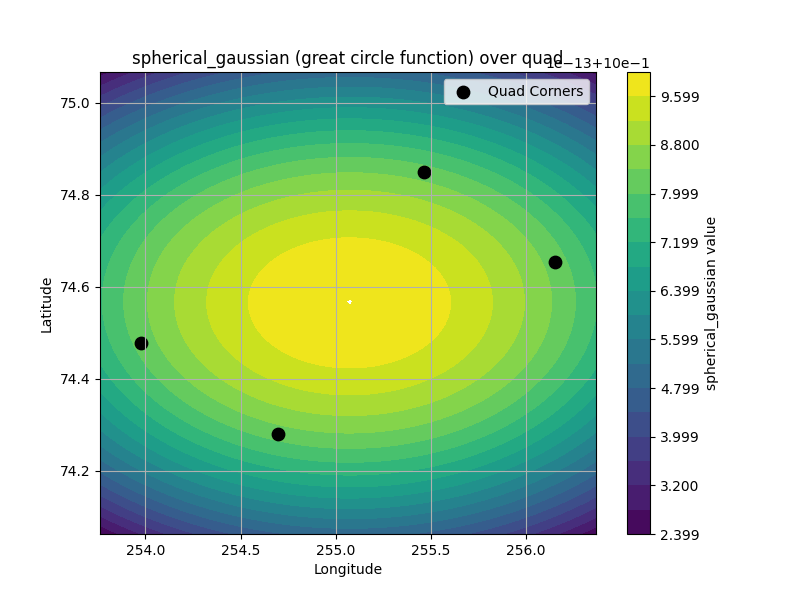

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Create grid covering the quad
x_min, x_max = min(x_corners), max(x_corners)
y_min, y_max = min(y_corners), max(y_corners)
padding = 0.1 * (x_max - x_min)
grid_x, grid_y = np.meshgrid(
    np.linspace(x_min - padding, x_max + padding, 100),
    np.linspace(y_min - padding, y_max + padding, 100)
)

# Evaluate spherical_gaussian on grid
grid_gc = spherical_gaussian(grid_x, grid_y)

plt.figure(figsize=(8, 6))
contour = plt.contourf(grid_x, grid_y, grid_gc, levels=20, cmap='viridis')
plt.colorbar(contour, label='spherical_gaussian value')
plt.scatter(x_corners, y_corners, color='black', label='Quad Corners', s=80)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('spherical_gaussian (great circle function) over quad')
plt.legend()
plt.grid(True)
plt.show()